In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import chess
import chesslib
import matplotlib.pyplot as plt
from teradataml import *

In [2]:
# Connect with Teradata Database
eng = create_context("192.168.56.1", "val", "val")
conn = get_connection()
replay_buffer_table = "replay_buffer"
replay_buffer_staging_table = "replay_buffer_stage"
states_table = "states"

In [3]:
query = 'SELECT TOP 100000 FEN, reward_aggregate FROM states;'
df = DataFrame(query=query)
pd_df = df.to_pandas()

In [4]:
board = chess.Board()
x_train_array = np.zeros((0,9,8,12))
y_train_array = np.zeros((0))
for index, row in pd_df.iterrows():
    #print(row[0])
    board.set_fen(row[0])
    y_train_array = np.append(y_train_array, row[1])
    x_train_raw = chesslib.board_to_array(board)
    x_train_row = np.expand_dims(x_train_raw, axis=0)
    x_train_array_temp = np.concatenate((x_train_array, x_train_row), axis=0)
    x_train_array = x_train_array_temp
print(x_train_array.shape)
print(y_train_array.shape)


X_train, X_val, y_train, y_val = train_test_split(x_train_array, y_train_array, test_size=0.2, random_state=42)

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [6]:

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(9,8,12)),  # Flatten the 12x9 matrix to a 1D array
    tf.keras.layers.Dense(64, activation='sigmoid'),  # First dense layer
    tf.keras.layers.Dense(32, activation='sigmoid'),    # Second dense layer
    tf.keras.layers.Dense(1, activation='tanh')    # Output layer with tanh activation
])

# Compile the model
model.compile(optimizer='adam', loss='MeanSquaredError', metrics=['accuracy'])

# Summary of the model
#model.summary()

In [7]:
history = model.fit(X_train, y_train, epochs=20, batch_size = 32, validation_data=(X_val, y_val))

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0818 - val_accuracy: 0.0000e+00 - val_loss: 0.0564
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0472 - val_accuracy: 0.0000e+00 - val_loss: 0.0545
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0367 - val_accuracy: 0.0000e+00 - val_loss: 0.0547
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0235 - val_accuracy: 0.0000e+00 - val_loss: 0.0549
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0145 - val_accuracy: 0.0000e+00 - val_loss: 0.0588
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0097 - val_accuracy: 0.0000e+00 - val_loss: 0.0602
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0063 - val_accuracy: 0.0000e+00 - val_loss: 0.0628
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/s

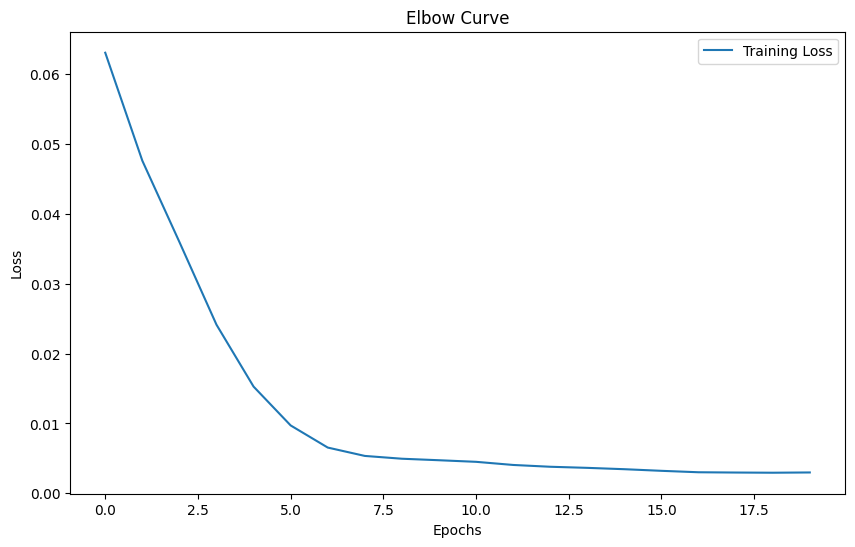

In [8]:
# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Elbow Curve')
plt.legend()
plt.show()

In [9]:
board.set_fen('rnbqkbnr/pppp1ppp/8/4p3/5P2/8/PPPPP1PP/RNBQKBNR w KQkq -')
new_test_array = chesslib.board_to_array(board)


#board.set_fen('1n1kr3/3p2np/1rb4b/pp3pp1/Pp1Pp2P/2BRPN2/2P1KPB1/R3N2Q b - -')
#new_test_array = chesslib.board_to_array(board)

new_test_array = np.expand_dims(new_test_array, axis=0)

In [10]:

model.predict(new_test_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


array([[0.04068056]], dtype=float32)

In [11]:
conn.close
remove_context()

True